# Prediction of reference annotations in CC Certificates (Raw)

This notebook:
- loads dataframe of a dataset with `(dgst, cert_id, sentences, label)`
- Trains a model to classify the sentences related to certificate reference to their common sentiment (meaning of reference)

In [1]:
# When on Aura, it is important to first set CUDA_VISIBLE_DEVICES environment variable directly from notebook
# For available GPUs, see https://www.fi.muni.cz/tech/unix/aura.html.cs

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-a5459e6a-b26d-5985-874c-528458a7728b"
print(os.getenv("CUDA_VISIBLE_DEVICES"))

import pandas as pd
from sec_certs.utils.nlp import prec_recall_metric
from ast import literal_eval
from pathlib import Path
from sec_certs.model.reference_classification import ReferenceClassifierTrainer
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

REPO_ROOT = Path("../../../").resolve()


def predict_and_fill_df(clf, df, label_mapping):
    """
    Given the classifier, dataframe and label mapping, will populate dataframe with predictions for simple inspection.
    """
    df_new = df.copy()
    y_proba = clf.predict_proba(df_new.sentences)
    df_new["y_proba"] = y_proba
    df_new["y_pred"] = df_new.y_proba.map(lambda x: label_mapping[np.argmax(x)])
    df_new["correct"] = df_new.label == df_new.y_pred
    return df_new

def eval_strings(series):
    return [list(literal_eval(x)) for x in series]

def filter_short_sentences(sentences, cert_id):
    return [x for x in sentences if len(x) > len(cert_id) + 20]

MIG-a5459e6a-b26d-5985-874c-528458a7728b


In [2]:
# Prepare dataset

df = (
    pd.read_csv("/var/tmp/xjanovsk/certs/sec-certs/datasets/reference_classification_dataset.csv")
    .loc[lambda df_: (df_.label.notnull())]
    .assign(sentences=lambda df_: eval_strings(df_.sentences)).loc[lambda df_: df_.label != "SELF"]
    .drop(columns="lang")
)
df.sentences = df.apply(lambda row: filter_short_sentences(row["sentences"], row["referenced_cert_id"]), axis=1)
df = df.loc[lambda df_: df_.sentences.map(len) > 0]

# Split into train/valid
df_train = df.loc[df.split == "train"].drop(columns="split")
df_valid = df.loc[df.split == "valid"].drop(columns="split")

# Use just few examples for learning
#df_train = df_train.sample(n=20)

In [3]:
trainer = ReferenceClassifierTrainer(df_train, df_valid, prec_recall_metric, "transformer")
trainer.train()
trainer.evaluate()

config.json not found in HuggingFace Hub
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset
***** Running training *****
  Num examples = 17040
  Num epochs = 1
  Total optimization steps = 1065
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1065 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****


Internal evaluation (of model working on individual sentences)
{'precision': 0.1261682242990654, 'recall': 0.1261682242990654}
Actual evaluation after ensemble soft voting
{'precision': 0.7032967032967034, 'recall': 0.7032967032967034}


In [4]:
# Take a look at misclassified instances
df_train = predict_and_fill_df(trainer.clf, df_train, trainer.label_mapping)
df_valid = predict_and_fill_df(trainer.clf, df_valid, trainer.label_mapping)

In [5]:
df_train.loc[~df_train.correct].head()

,dgst,referenced_cert_id,label,sentences,y_proba,y_pred,correct
762,ab3af998dff7a2ef,ANSSI-CC-2017/47,COMPONENT_USED,[ANSSI-CC-2017/47 le 5 septembre 2017.\n],"[0.20525086358002373, 0.18348274934762435, 0.1...",ON_PLATFORM,False


In [6]:
df_valid.loc[~df_valid.correct].head()

,dgst,referenced_cert_id,label,sentences,y_proba,y_pred,correct
13,031667f4e242da61,CCEVS-VR-07-0054,ON_PLATFORM,[Red Hat Enterprise Linux AS (version 5)\nfor ...,"[0.08128229341724993, 0.5935885753661718, 0.08...",COMPONENT_USED,False
93,0fe8df0e85116b61,ANSSI-CC-2010/33,COMPONENT_SHARED,[CC IDeal Citiz (sur\ncomposants SB23YR80B et ...,"[0.1298013287690078, 0.3509932910135731, 0.129...",COMPONENT_USED,False
120,16abf8ee0697e64f,ANSSI-CC-2014/61,COMPONENT_SHARED,[sous la référence [ANSSI-CC-2014/61].\n],"[0.31989947871327085, 0.1360383985847733, 0.13...",ON_PLATFORM,False
186,22388445fe620ac0,ANSSI-CC-2014/20,EVALUATION_REUSED,[[ANSSI-CC-\n2014/20]\nRapport de certificatio...,"[0.24887785969701517, 0.3029851841704751, 0.11...",COMPONENT_USED,False
201,24de96ea505af909,ANSSI-CC-2021/29,ON_PLATFORM,[[CER-PLF] Rapport de certification ANSSI-CC-2...,"[0.11465163411016323, 0.5243168025861568, 0.07...",COMPONENT_USED,False


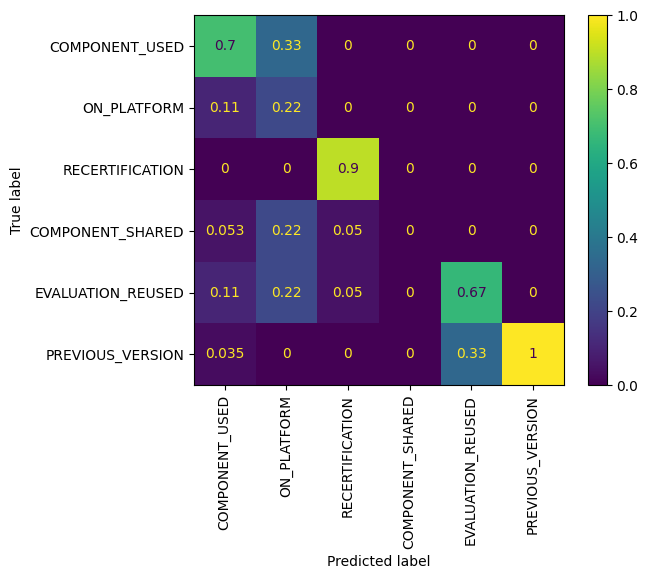

In [7]:
ConfusionMatrixDisplay.from_predictions(df_valid.label, df_valid.y_pred, labels=df_valid.label.unique(), display_labels=df_valid.label.unique(), xticks_rotation=90, normalize="pred")

In [8]:
df_valid.label.value_counts()

COMPONENT_USED       43
RECERTIFICATION      18
EVALUATION_REUSED    11
ON_PLATFORM           8
COMPONENT_SHARED      6
PREVIOUS_VERSION      5
Name: label, dtype: int64

In [9]:
# Experiments with ensemble for soft-voting on top of the base model.
# But this is dump, since the ensemble is position-specific w.r.t. sequence, while the individual sentences are not.
from sklearn.ensemble import RandomForestClassifier

df_train["y_proba_base"] = df_train.sentences.map(trainer._model.predict_proba).map(lambda x: x.flatten())
feat_len = df_train["y_proba_base"].map(len).max()
df_train["rf_feature_vector"] = df_train.y_proba_base.map(lambda x: np.pad(x, pad_width=(0, feat_len - len(x))))

df_valid["y_proba_base"] = df_valid.sentences.map(trainer._model.predict_proba).map(lambda x: x.flatten())
df_valid["rf_feature_vector"] = df_valid.y_proba_base.map(lambda x: np.pad(x, pad_width=(0, feat_len - len(x))))

clf = RandomForestClassifier()
clf = clf.fit(df_train.rf_feature_vector.tolist(), df_train.label)

df_train["rf_predict"] = clf.predict(df_train.rf_feature_vector.tolist())
df_valid["rf_predict"] = clf.predict(df_valid.rf_feature_vector.tolist())